In [1]:
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
from collections import defaultdict
import copy
import random
import numba as nb

In [2]:
# @nb.jit()
def localAffine(target, U, target_U, epsilon=1):
    '''局部仿射函数,寻找X=T^{-1} (Y)的函数关系，即position_map'''

    height, width= target.shape
    position_map = defaultdict(lambda: np.zeros(3))  # 构造position_map映射字典，初始为0向量

    # 得到Gi
    G_inv = defaultdict(lambda: np.eye(3))  # 初始化Gi，字典内是3*3的初始单位矩阵
    num_control = len(U) # 控制点个数
    for each_point in range(num_control):#改变（1，3）和（2，3）位置的元素为位移量
        G_inv[each_point][0:2,2] = U[each_point] - target_U[each_point] # 变换矩阵利用控制点在两张图上的位移得到

    for x in range(height):
        for y in range(width): # 遍历每个个点
            Y = (x,y)
            distance = np.sqrt((np.square(np.array(Y) - target_U, dtype='int64')).sum(axis=1))  # Y到target图中每一个控制点的距离
            w = 1 / (distance ** epsilon) if distance.all() else np.ones(num_control)
            # 如果不是控制点正常更新w，否则先随便赋一个值，下面再统一更新控制点
            w = w / w.sum()
            for i in range(num_control):
                Gi_X = np.dot(G_inv[i], np.array([x,y,1]))
                position_map[Y] += w[i] * Gi_X    # 利用w对Gi加权
            position_map[Y] = position_map[Y][:2]     # 把向量最后的1去除

    for i in range(num_control):
        position_map[tuple(target_U[i])] = U[i] # 控制点Y的映射就是X
    return position_map

# @nb.jit()
# 后向变换
def backwardTrans(source, target, position_map):# position_map对应local affine返回的结果
    height,width = target.shape[0],target.shape[1]

    # 对每个像素点标志是否已经填过
    is_paint = np.zeros((height,width),dtype='uint8')
    # print(is_paint.shape)
    '''根据变换函数position_map完成反向图变换'''

    newImg = np.zeros_like(target)   # 变换后的target
    for i in range(height):
        for j in range(width): # 遍历target每一个像素点
            X = position_map[i, j] # source中对应的点（精确位置）
            u, v = X - X.astype(int)
            neigh_i, neigh_j = X.astype(int) # 得到附近像素点和垂直水平距离u,v
            # 进行插值，得到X位置的像素值，也就是newImg在Y处像素值
            if neigh_i < 0 or neigh_j < 0 or neigh_i+1 >source.shape[0]-1  or neigh_j+1 >source.shape[1]-1:
                is_paint[i,j]=1
                continue #如果这个点的位置出界了就不填
            newImg[i,j] = (1 - u) * (1 - v) * source[neigh_i, neigh_j] + (1 - u) * v * source[neigh_i,neigh_j + 1] +\
                    u * (1 - v) * source[neigh_i +1,neigh_j] +  u * v * source[neigh_i + 1,neigh_j + 1]

    
    # 对没有填的区域进行修复
    newImg = cv2.inpaint(newImg, is_paint, 13, cv2.INPAINT_NS)

    return newImg.astype(np.uint8)  # 变成像素需要的int

In [3]:
#FFD代码：
def Bspline_Ffd_kernel(source, out, row_block_num, col_block_num, grid_points):
    BPLINE_BOARD_SIZE=3
    row, col = source.shape
    delta_x = col*1.0/col_block_num; #列的块长度
    delta_y = row*1.0/row_block_num;#行的块长度
    grid_rows = row_block_num + BPLINE_BOARD_SIZE
    grid_cols = col_block_num + BPLINE_BOARD_SIZE #加padding目的是防止越界
    grid_size = grid_rows*grid_cols #网格大小
    for y in range(row): 
      for x in range(col):
        x_block = x / delta_x #在第几块
        y_block = y / delta_y #在第几块
        
        j = np.floor(x_block)#取整
        i = np.floor(y_block)#取整
        u = x_block - j#该点距离块边界的距离
        v = y_block - i

        #B样条基函数
        pX=np.zeros((4))
        pY=np.zeros((4))
        pX[0] = (1 - u*u*u + 3*u*u - 3*u) / 6.0
        pX[1] = (4 + 3*u*u*u - 6*u*u) / 6.0
        pX[2] = (1 - 3*u*u*u + 3*u*u + 3*u) / 6.0
        pX[3] = u*u*u / 6.0
        pY[0] = (1 - v*v*v + 3*v*v - 3*v) / 6.0
        pY[1] = (4 + 3*v*v*v - 6*v*v) / 6.0
        pY[2] = (1 - 3*v*v*v + 3*v*v + 3*v) / 6.0
        pY[3] = v*v*v / 6.0

        Tx = x
        Ty = y
        for m in range(4):
          for n in range(4):
            control_point_x = j + n
            control_point_y = i + m #控制点的位置
            temp = pY[m] * pX[n] #B样条
            # print(control_point_y*grid_cols+control_point_x)
            Tx += temp*grid_points[np.int32(control_point_y*grid_cols+control_point_x)]#累加x
            Ty += temp*grid_points[np.int32(control_point_y*grid_cols+control_point_x+grid_size)]
        x1 = np.int32(Tx)
        y1 = np.int32(Ty)
        
        if (x1 < 1 or x1 >= col-1 or y1 < 1 or y1 >= row-1):#越界
          out[y,x] = 0    #直接设为黑色
        else:
          x2 = x1 + 1   
          y2 = y1 + 1
          # print(y1,col,x1)
          #双线性插值
          gray = (x2 - Tx)*(y2 - Ty)*source[y1,x1] - \
              (x1 - Tx)*(y2 - Ty)*source[y1,x2] - (x2 - Tx)*(y1 - Ty)*source[y2,x1] + \
                              (x1 - Tx)*(y1 - Ty)*source[y2,x2]
          out[y,x] = gray
    return out

In [4]:
# 随机生成2*(row_block_num+3)*(col_block_num+3)个范围在min~max之间的随机数作为控制参数：
def init_param(source, row_block_num, col_block_num, min_x, max_x):
  grid_rows = row_block_num + BPLINE_BOARD_SIZE;
  grid_cols = col_block_num + BPLINE_BOARD_SIZE;
  grid_size = grid_rows*grid_cols;
#   grid_points=np.zeros((2*grid_size, 1))
#   grid_points_data = grid_points.ptr<float>(0)
#   for i in range(2*grid_size):
#     grid_points_data[i] = random.random(min_x, max_x)  #生成x   
  grid_points = (max_x-min_x) * np.random.random_sample((2*grid_size)) +min_x
  return grid_points


In [5]:
source = cv2.imread("float2.jpg" ,cv2.IMREAD_GRAYSCALE)     # 人脸，现在先尝试用灰色图片
target = cv2.imread("base2.jpg" ,cv2.IMREAD_GRAYSCALE)       # 大猩猩
target = cv2.resize(target, source.shape[::-1])
row_block_num = 30
col_block_num = 30
grid_points = init_param(target, row_block_num, col_block_num, -10, 10)
out = target.copy()
out = Bspline_Ffd_kernel(target, out, row_block_num, col_block_num, grid_points)
plt.subplot(1, 2, 1), plt.axis("off")
plt.imshow(target,cmap='gray'),plt.title('baseline')
plt.subplot(1, 2, 2), plt.axis("off")
plt.imshow(out,cmap='gray'),plt.title('out')


NameError: name 'BPLINE_BOARD_SIZE' is not defined

In [ ]:
# @nb.jit()
def cal_ncc(source, target, row, col):
    '''
    归一化互相关系数，用分块计算的方法
    input: source, target, row, col
    output: ncc
    '''
    row_size = int(source.shape[0]/row)
    col_size = int(source.shape[1]/col)
    ncc=0
    for i in range(row):
        i_begin = i*row_size
        for j in range(col):
            sum1=0
            sum2=0
            sum3=0
            j_begin = j*col_size
            for t1 in range(i_begin,np.min((source.shape[0],i_begin+row_size))):
                for t2 in range(j_begin,np.min((source.shape[1],j_begin+col_size))):
                    sum1+=int(source[t1,t2])*int(target[t1,t2])#a*b,转成int防止数值溢出
                    sum2+=np.square(source[t1,t2],dtype='int64') #a**2，转成int64防止数值溢出
                    sum3+=np.square(target[t1,t2],dtype='int64') #b**2，转成int64防止数值溢出
            # print(sum1)
            ncc+=np.sqrt(sum2*sum3)/(sum1+0.0000000001)#防止分母为0
    ncc/=(row*col)
    return ncc



In [ ]:
# @nb.jit()
def get_local_affine(source, target, grid_points):
    '''
    计算目标函数 包含三部分: transform+插值+计算互相关
    input: source, target, grid_points
    output: ncc value
    '''
    U,U_target = np.array_split(grid_points, 2)
    U = U.reshape((-1,2))
    U_target = U_target.reshape((-1,2))#提取出两个控制点
    position_map = localAffine(target, U, U_target, 0.7)# 得到Y和X对应关系
    newImg1 = backwardTrans(source, target, position_map) # 利用反向变换得到新图片
    result = cal_ncc(newImg1,target,5,5)#分5*5的小块计算互相关
    return result

In [ ]:
# @nb.jit()
def cal_gradient(source,target,grid_points,gradient):
    '''
    计算梯度（感觉逻辑还有点问题)
    input: source, target,grid_points, old gradient
    output: new gradient update
    '''
    eps=1#超参数，可以改
    # gradient = np.zeros_like(grid_points)
    a1=get_local_affine(source,target,grid_points)
    grid_p = grid_points.copy()
    for i in range(grid_points.shape[0]):
        grid_p[i]+=eps #修改grid的i位元素的大小
        a2 = get_local_affine(source, target, grid_p) #每次都要做一次仿射+相似度估计
        grid_p[i]-=eps #再把它改回来
        # print(a2,a1)
        gradient[i] = (a2-a1)/eps#梯度
    return gradient

In [ ]:
def update_grid_points(grid_points, gradient, alpha):
    '''
    根据梯度下降的逻辑更新grid
    '''
    for i in range(grid_points.shape[0]):
        print(gradient[i]*alpha)
        grid_points[i]=grid_points[i]-gradient[i]*alpha
    return grid_points

In [ ]:
def optimization(source, target, grid_points):
    '''
    最优化迭代的具体步骤
    超参数需要进一步调整
    '''
    max_iter=50#最多迭代次数
    e =0.0005#迭代精度
    ret1=0
    ret2=0
    count=0#迭代次数统计
    alpha = 4000#初始alpha
    gradient = np.zeros_like(grid_points,dtype='float')#初始化梯度
    gradient=cal_gradient(source, target, grid_points, gradient)
    out_cnt=0
    while count<max_iter:
        print('第 ',count,'次迭代:')
        pred_grid_points= grid_points.copy()
        grid_points = update_grid_points(grid_points,gradient,alpha)
        ret1 = get_local_affine(source, target, pred_grid_points)#原本点的相关系数
        ret2 = get_local_affine(source, target, grid_points)#更新后点的相关系数
        print('original:%9f'%ret1,'after: %9f'%ret2,', alpha=',alpha)
        if ret2>ret1: #如果当前轮迭代的目标函数值大于上一轮的函数值，则减小步长并重新计算梯度、重新更新参数
            if alpha < 0.01: 
                '''这一块到时候可能要删，因为现在跑的时候alpha都1e-6了还在减小'''
                U,U_target = np.array_split(grid_points, 2)
                U = U.reshape((-1,2))
                U_target = U_target.reshape((-1,2)) #变换图和参考图的控制点
                position_map = localAffine(target, U, U_target, 0.7)# 得到Y和X对应关系
                float = backwardTrans(source, target, position_map) # 利用反向变换得到新图片
                return float
            alpha*=0.5
            grid_points = pred_grid_points.copy()
            print('update alpha...')
            continue
        if np.abs(ret2-ret1)<e: #如果前后的变化比e小
            out_cnt+=1
            print('small enough!')
            if out_cnt>=2: #如果连续2次目标函数值不变则认为达到最优解停止迭代
                U,U_target = np.array_split(grid_points, 2)
                U = U.reshape((-1,2))
                U_target = U_target.reshape((-1,2)) #变换图和参考图的控制点
                position_map = localAffine(target, U, U_target, 0.7)# 得到Y和X对应关系
                float = backwardTrans(source, target, position_map) # 利用反向变换得到新图片
                return float
        else:
            out_cnt=0
        pre_gradient = gradient.copy()
        gradient = cal_gradient(source, target, grid_points,gradient)#计算新的梯度
        if np.linalg.norm(gradient,2)>np.linalg.norm(pre_gradient,2): #如果新的梯度比原来的二范数大，则增加alpha步长
            print('add alpha')
            alpha*=2
        count+=1
    return -1

In [ ]:
def main_local_affine():
    source = cv2.imread("float2.jpg" ,cv2.IMREAD_GRAYSCALE)     # 人脸，现在先尝试用灰色图片
    target = cv2.imread("base2.jpg" ,cv2.IMREAD_GRAYSCALE)       # 大猩猩
    target = cv2.resize(target, source.shape[::-1])
    # print(source.shape)
    # print(target.shape)
    '''
    初始数据点需要调
    '''
    U = np.array([[190, 169], [193, 207], [193, 231], [186, 249], [198, 223], 
                        [232, 208], [234, 233], [259, 185], [253, 227]]) # 人脸控制点
    U_target = np.array([[194, 171], [199, 202], [197, 230], [192, 255], [199, 220], 
                        [238, 205], [237, 232], [260, 184], [259, 231]])#参照物控制点
    #########################################################################################

    # source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB) #cv2默认是BGR，我们转成RGB
    # target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
    out=-1

    grid_points = np.concatenate((U,U_target))
    grid_points.reshape((-1))#变成一维向量
    # grid_points.astype(np.unit8)
    out = optimization(source, target, out,grid_points)

    if type(out) == type(1):        
        print('maximum iteration exceeded!')
        return
    print('success!')
    diff = np.abs(np.array(target,dtype='int64')-np.array(out,dtype='int64'))

    plt.subplot(2, 2, 1), plt.axis("off")
    plt.imshow(source,cmap='gray'),plt.title('float')
    plt.subplot(2, 2, 2), plt.axis("off")
    plt.imshow(target,cmap='gray'),plt.title('baseline')
    plt.subplot(2, 2, 3), plt.axis("off")
    plt.imshow(out,cmap='gray'),plt.title('out')
    cv2.imwrite('out.jpg', out) 
    plt.subplot(2, 2, 4), plt.axis("off")
    plt.imshow(diff,cmap='gray'),plt.title('out-base')

第  0 次迭代:
[-2.41285071 -2.41285071]
[-1.78236612 -1.78236612]
[-1.33826829 -1.33826829]
[-1.01118227 -1.01118227]
[-1.37926221 -1.37926221]
[-2.4026005 -2.4026005]
[-1.42418677 -1.42418677]
[-3.01127169 -3.01127169]
[-2.48229572 -2.48229572]
[2.20930083 2.20930083]
[1.41488811 1.41488811]
[1.01419523 1.01419523]
[0.80593822 0.80593822]
[1.13762299 1.13762299]
[1.38954499 1.38954499]
[1.00827053 1.00827053]
[1.68645603 1.68645603]
[0.88475255 0.88475255]
original: 1.025966 after:  1.025345 , alpha= 4000
add alpha
第  1 次迭代:
[8.9969876 8.9969876]
[8.65836416 8.65836416]
[8.71590272 8.71590272]
[8.69254209 8.69254209]
[8.70566151 8.70566151]
[8.42276919 8.42276919]
[8.60932006 8.60932006]
[8.2257258 8.2257258]
[8.43460786 8.43460786]
[-8.62348038 -8.62348038]
[-7.84190043 -7.84190043]
[-7.58557828 -7.58557828]
[-7.16855986 -7.16855986]
[-7.69613605 -7.69613605]
[-7.79744152 -7.79744152]
[-7.41752705 -7.41752705]
[-8.08628011 -8.08628011]
[-7.22206788 -7.22206788]
original: 1.025345 after: 

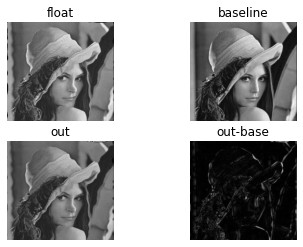

In [ ]:
# main_local_affine()

(<matplotlib.image.AxesImage at 0x2e7e54868e0>, Text(0.5, 1.0, 'out-base'))

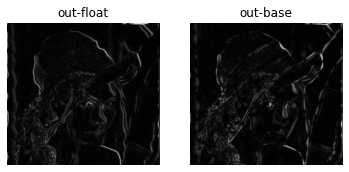

In [ ]:
# source = cv2.imread("float2.jpg" ,cv2.IMREAD_GRAYSCALE)     # 浮动图像，现在先尝试用灰色图片
# out = cv2.imread("out.jpg" ,cv2.IMREAD_GRAYSCALE)       # 最终输出图像
# target = cv2.imread("base2.jpg" ,cv2.IMREAD_GRAYSCALE)       # 基准图像
# target = cv2.resize(target, source.shape[::-1])
# # target = cv2.resize(target, source.shape[::-1])
# plt.subplot(1, 2, 1), plt.axis("off")
# diff = np.abs(np.array(source,dtype='int64')-np.array(out,dtype='int64'))#浮动和out
# plt.imshow(diff,cmap='gray'),plt.title('out-float')

# plt.subplot(1, 2, 2), plt.axis("off")
# diff2 = np.abs(np.array(target,dtype='int64')-np.array(out,dtype='int64'))#基准和out
# plt.imshow(diff2,cmap='gray'),plt.title('out-base')

In [ ]:
def main_ffd():
    source = cv2.imread("float2.jpg" ,cv2.IMREAD_GRAYSCALE)     # 人脸，现在先尝试用灰色图片
    target = cv2.imread("base2.jpg" ,cv2.IMREAD_GRAYSCALE)       # 大猩猩
    target = cv2.resize(target, source.shape[::-1])
    row_block_num = 3
    col_block_num = 3
    grid_points = init_param(target, row_block_num, col_block_num, -10, 10)
    out=-1
    out = optimization(source, target, grid_points)

    diff = np.abs(np.array(target,dtype='int64')-np.array(out,dtype='int64'))

    plt.subplot(2, 2, 1), plt.axis("off")
    plt.imshow(source,cmap='gray'),plt.title('float')
    plt.subplot(2, 2, 2), plt.axis("off")
    plt.imshow(target,cmap='gray'),plt.title('baseline')
    plt.subplot(2, 2, 3), plt.axis("off")
    plt.imshow(out,cmap='gray'),plt.title('out')
    cv2.imwrite('out.jpg', out) 
    plt.subplot(2, 2, 4), plt.axis("off")
    plt.imshow(diff,cmap='gray'),plt.title('out-base')

main_ffd()
    